# **Project Alpha**

## Dependencies

In [1]:
import json
import pandas as pd
import numpy as np
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display import display, HTML


## Settings


In [2]:
# Set the display option
pd.set_option('display.expand_frame_repr', False)

data_file = 'data/Sample data.json'
clean_file = 'data/clean_data.json'

## Load Data - Test

In [3]:

# Check if the file exists
if os.path.exists(data_file):
    # Try to load and parse the JSON in the file
    try:
        with open(data_file, 'r') as f:
            data = json.load(f)
        df = pd.DataFrame(data)
        print(df.head())
    except Exception as e:
        print(f"An error occurred: {type(e).__name__}, {str(e)}")
else:
    print(f"The file {data_file} does not exist.")

An error occurred: JSONDecodeError, Expecting property name enclosed in double quotes: line 3 column 4 (char 8)


In [4]:
# Check if the file exists
if os.path.exists(data_file):
    # Read the file
    with open(data_file, 'r') as f:
        data = f.read()

    # Replace single quotes with double quotes
    data = data.replace("'", '"')

    # Write the result back to the file
    with open(clean_file, 'w') as f:
        f.write(data)
    print(f"Cleaned data written to {clean_file}.")
else:
    print(f"The file {clean_file} does not exist.")

Cleaned data written to data/clean_data.json.


## Data Cleaning

### Restructuring data so that each row represents a single response for a given year

First JSON object contains the company names in the 'Response' fields, so using the first row of the DataFrame to rename the columns before melting. 

In [5]:
# Load data
df = pd.read_json(clean_file)

# Get the first row of the DataFrame
first_row = df.iloc[0]

# Create a dictionary mapping the old column names to the new ones
column_mapping = {f'Response {i+1}': first_row[f'Response {i+1}'] for i in range(5)}

# Rename the columns
df.rename(columns=column_mapping, inplace=True)

# Drop the first row
df.drop(df.index[0], inplace=True)

# Melt the DataFrame
df_melted = df.melt(id_vars=[ 'Question level 1', 'Question level 2', 'Question level 3'], 
                    value_vars=list(column_mapping.values()), 
                    var_name='Company', 
                    value_name='Response')


# Convert responses to numeric
df_melted['Response'] = pd.to_numeric(df_melted['Response'], errors='coerce')
df_melted['Response'] = df_melted['Response'].round(0)

# add year column
df_melted['Year'] = df_melted['Question level 2'].str.extract('(\d{4})')
# Convert 'Year' to datetime format
df_melted['Year'] = pd.to_datetime(df_melted['Year'], format='%Y').dt.year

# add period description column
df_melted['Period'] = df_melted['Question level 2'].str.extract('([A-Za-z\s]+)')
df_melted['Period'] = df_melted['Period'].str.strip()
# Fill empty 'Period' cells with 'EoY'
df_melted['Period'] = df_melted['Period'].fillna('EoY')
# Capitalize all values in 'Period' column
df_melted['Period'] = df_melted['Period'].str.upper()


# Fill NaN values with 0
df_melted.fillna(0, inplace=True)

# drop EoY 2024 in 'Question level 2' columns as EoY 2024 is not a valid value in the real world scenario
df_melted = df_melted[df_melted['Question level 2'] != 'EoY 2024']

# Rename the column
df_melted = df_melted.rename(columns={'Question level 1': 'Category',
                                      'Question level 3': 'Value'})

# Define a dictionary for the replacements
replacements = {
    'What was your AuM split over the last 5 years?': 'AUM Split',
    'What was your revenue in the last 5 years?': 'Revenue',
    'What was your total AuM in the last 5 years?': 'AUM'
}

# Replace the values
df_melted['Category'] = df_melted['Category'].replace(replacements)



## Pivot the DataFrame to have each response as a separate column for each year.

In [6]:
# Pivot the DataFrame
df_pivot = df_melted.pivot_table(index=['Company', 'Year'],
                                 columns=[  'Value', 'Category'], 
                                 values='Response').reset_index()
# Flatten the MultiIndex in columns
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]


## Calculations

### Outliers

In [7]:
# 'Fixed income_AUM Split'
## Calculate average value for 'Fixed income_AUM Split' for Company C excluding the year 2022
average_value = df_pivot.loc[(df_pivot['Company_'] == 'Company C') & (df_pivot['Year_'] != 2022), 'Fixed income_AUM Split'].mean()
## Replace the value for the year 2022 with the calculated average
df_pivot.loc[(df_pivot['Company_'] == 'Company C') & (df_pivot['Year_'] == 2022), 'Fixed income_AUM Split'] = average_value

# 'Total_Revenue'
## Calculate average value for 'Total Revenue' for Company C excluding the year 2022
average_value = df_pivot.loc[(df_pivot['Company_'] == 'Company C') & (df_pivot['Year_'] != 2022), 'Total_Revenue'].mean()
## Replace the value for the year 2022 with the calculated average
df_pivot.loc[(df_pivot['Company_'] == 'Company C') & (df_pivot['Year_'] == 2022), 'Total_Revenue'] = average_value


### Columns clean-up


In [8]:
# assuming all figures are in million, divide by 1000 to convert to million
df_pivot['Total_Revenue'] = df_pivot['Total_Revenue'] / 1000
# Calculate 'Total AUM'
df_pivot['Total_AUM_calc'] = df_pivot['Fixed income_AUM Split'] + df_pivot['Hedge funds_AUM Split'] + df_pivot['Multi-asset_AUM Split'] + df_pivot['Other_AUM Split'] + df_pivot['Private Debt_AUM Split'] + df_pivot['Private Equity_AUM Split'] + df_pivot['Public equities_AUM Split'] 

# AUM calculation check
df_pivot['AUM_Check'] = np.where(df_pivot['Total_AUM'] == df_pivot['Total_AUM_calc'], 'True', 'False')
#AUM calculation check difference
df_pivot['AUM_Check_Diff'] = df_pivot['Total_AUM'] - df_pivot['Total_AUM_calc']

# Calculate '% PE in AUM'
df_pivot['PE_AUM(%)'] = df_pivot['Private Equity_AUM Split'] / df_pivot['Total_AUM_calc'] 

# Calculate '% HF in AUM'
df_pivot['HF_AUM(%)'] = df_pivot['Hedge funds_AUM Split'] / df_pivot['Total_AUM_calc'] 

# Calculate '% PE in Revenue'
df_pivot['Revenue_PE(£)'] = df_pivot['PE_AUM(%)'] * df_pivot['Total_Revenue'] 

# Calculate '% HF in Revenue'
df_pivot['Revenue_HF(£)'] = df_pivot['HF_AUM(%)']  * df_pivot['Total_Revenue'] 

# calculate revenue in basis points
df_pivot['Revenue_bps'] = df_pivot['Total_Revenue'] / df_pivot['Total_AUM_calc'] * 10000

# Calculate 4-year CAGR
df_pivot['AUM_4Y_CAGR(%)'] = ((df_pivot['Total_AUM_calc'] / df_pivot['Total_AUM_calc'].shift(4)) ** (1/4)) - 1
df_pivot['Revenue_4Y_CAGR(%)'] = ((df_pivot['Total_Revenue'] / df_pivot['Total_Revenue'].shift(4)) ** (1/4)) - 1

df_pivot.rename(columns={
                        'Company_': 'Manager Name',
                        'Year_':'Year',
                        'AUM_Check': 'AUM Check',
                        'AUM_Check_Diff': 'AUM Check Diff',
                        'Fixed income_AUM Split': 'Fixed Income AUM',
                        'Hedge funds_AUM Split': 'Hedge Funds AUM',
                        'Multi-asset_AUM Split': 'Multi-Asset AUM',
                        'Other_AUM Split': 'Other AUM',
                        'Private Debt_AUM Split': 'Private Debt AUM',
                        'Private Equity_AUM Split': 'Private Equity AUM',
                        'Public equities_AUM Split': 'Public Equities AUM',
                        'Total_AUM': 'Total AUM Original',
                        'Total_Revenue': 'Total Revenue',
                        'Total_AUM_calc': 'Total AUM',      # calculated total AUM
                        'PE_AUM(%)': 'PE AUM(%)',
                        'HF_AUM(%)': 'HF AUM(%)',
                        'Revenue_PE(£)': 'Revenue PE(£)',
                        'Revenue_HF(£)': 'Revenue HF(£)',
                        'Revenue_bps': 'Revenue bps',
                        'AUM_4Y_CAGR(%)': 'AUM 4Y CAGR(%)',
                        'Revenue_4Y_CAGR(%)': 'Revenue 4Y CAGR(%)'
                        }, inplace=True)


#drop 'Company E' for 'Year' 2020 as it has no data
df_pivot = df_pivot[~((df_pivot['Manager Name'] == 'Company E') & (df_pivot['Year'] == 2020))]

display(df_pivot.head(5))



,Manager Name,Year,Fixed Income AUM,Hedge Funds AUM,Multi-Asset AUM,Other AUM,Private Debt AUM,Private Equity AUM,Public Equities AUM,Total AUM Original,...,Total AUM,AUM Check,AUM Check Diff,PE AUM(%),HF AUM(%),Revenue PE(£),Revenue HF(£),Revenue bps,AUM 4Y CAGR(%),Revenue 4Y CAGR(%)
0,Company A,2020,1000.0,400.0,800.0,300.0,700.0,600.0,500.0,0.0,...,4300.0,False,-4300.0,0.139535,0.093023,0.498000,0.332000,8.300000,NaN,NaN
1,Company A,2021,1050.0,410.0,820.0,310.0,720.0,620.0,520.0,0.0,...,4450.0,False,-4450.0,0.139326,0.092135,0.529020,0.349836,8.532584,NaN,NaN
2,Company A,2022,1100.0,420.0,840.0,320.0,740.0,640.0,540.0,0.0,...,4600.0,False,-4600.0,0.139130,0.091304,0.561391,0.368413,8.771739,NaN,NaN
3,Company A,2023,1150.0,430.0,860.0,330.0,760.0,800.0,560.0,0.0,...,4890.0,False,-4890.0,0.163599,0.087935,0.721309,0.387703,9.016360,NaN,NaN
4,Company A,2024,1213.0,657.0,885.0,343.0,785.0,1047.0,585.0,0.0,...,5515.0,False,-5515.0,0.189846,0.119130,0.917905,0.575992,8.766999,0.06419,0.078854


# Summary Table

In [9]:
# Filter for the latest year and period
latest_data = df_pivot[df_pivot['Year'] == df_pivot['Year'].max()]

# Group by 'Company' and 'Year'
summary_table = latest_data.groupby(['Manager Name', 'Year'])[['Total AUM',  'PE AUM(%)', 'HF AUM(%)','AUM 4Y CAGR(%)','Total Revenue','Revenue PE(£)','Revenue HF(£)','Revenue 4Y CAGR(%)']].sum()

# Reset the index
summary_table = summary_table.reset_index()

# Replace inf with NaN
summary_table.replace([np.inf, -np.inf], np.nan, inplace=True)

# format the columns
summary_table['Total AUM'] = summary_table['Total AUM'].map('{:,.0f}'.format)
summary_table['PE AUM(%)'] = summary_table['PE AUM(%)'].map('{:.2%}'.format)
summary_table['HF AUM(%)'] = summary_table['HF AUM(%)'].map('{:.2%}'.format)
summary_table['AUM 4Y CAGR(%)'] = summary_table['AUM 4Y CAGR(%)'].map('{:.2%}'.format)
summary_table['Total Revenue'] = summary_table['Total Revenue'].map('{:,.1f}'.format)
summary_table['Revenue PE(£)'] = summary_table['Revenue PE(£)'].map('{:,.1f}'.format)
summary_table['Revenue HF(£)'] = summary_table['Revenue HF(£)'].map('{:,.1f}'.format)
summary_table['Revenue 4Y CAGR(%)'] = summary_table['Revenue 4Y CAGR(%)'].map('{:.2%}'.format)

# Print the summary table
print('AUM and Revenue in Million £')
print('')

html_table = (tabulate(summary_table, headers='keys', tablefmt='html', showindex=False))

# Display the table
display(HTML(html_table))

print('')
print('*nan% means that the data is not available')

AUM and Revenue in Million £



Manager Name,Year,Total AUM,PE AUM(%),HF AUM(%),AUM 4Y CAGR(%),Total Revenue,Revenue PE(£),Revenue HF(£),Revenue 4Y CAGR(%)
Company A,2024,"5,515",18.98%,11.91%,6.42%,4.8,0.9,0.6,7.89%
Company B,2024,"4,276",19.71%,7.97%,4.76%,3.6,0.7,0.3,7.75%
Company C,2024,"6,309",14.82%,7.85%,1.69%,5.1,0.8,0.4,7.13%
Company D,2024,"7,629",12.12%,10.66%,2.70%,6.5,0.8,0.7,5.08%
Company E,2024,"5,617",67.81%,13.32%,nan%,5.4,3.6,0.7,nan%



*nan% means that the data is not available


# AUM Profile


### AUM changes over time

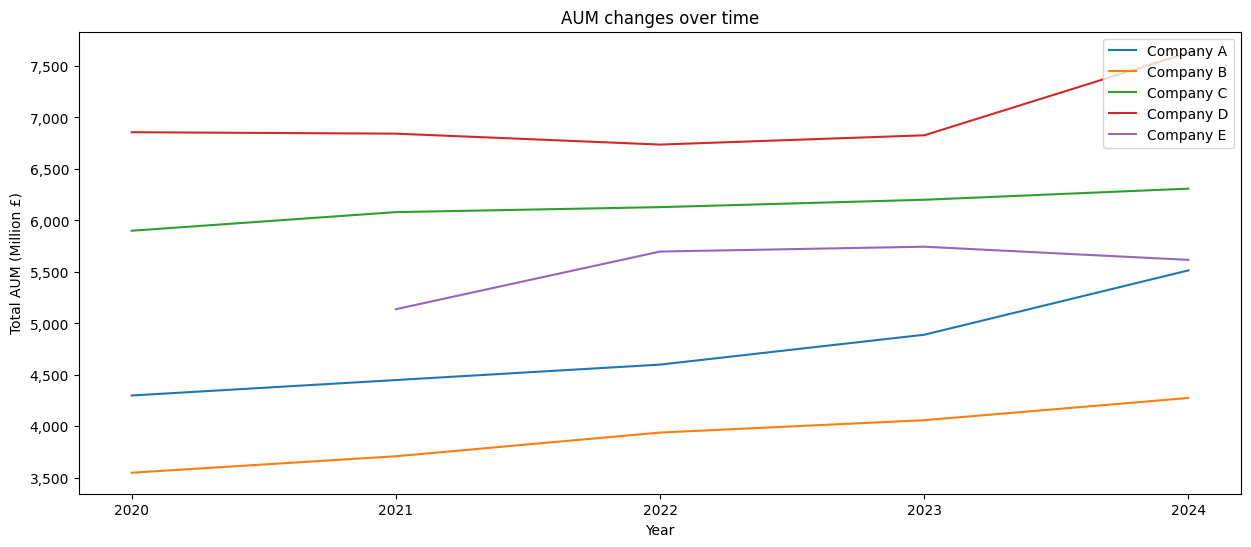

In [10]:
# Plot the AUM changes over time
companies = df_pivot['Manager Name'].unique()

fig, ax = plt.subplots(figsize=(15,6))

for company in companies:
    company_data = df_pivot[df_pivot['Manager Name'] == company]
    ax.plot(company_data['Year'], company_data['Total AUM'], label=company)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xlabel('Year')
ax.set_ylabel('Total AUM (Million £)')
ax.set_title('AUM changes over time')
ax.legend()

plt.show()

### AUM Distribution

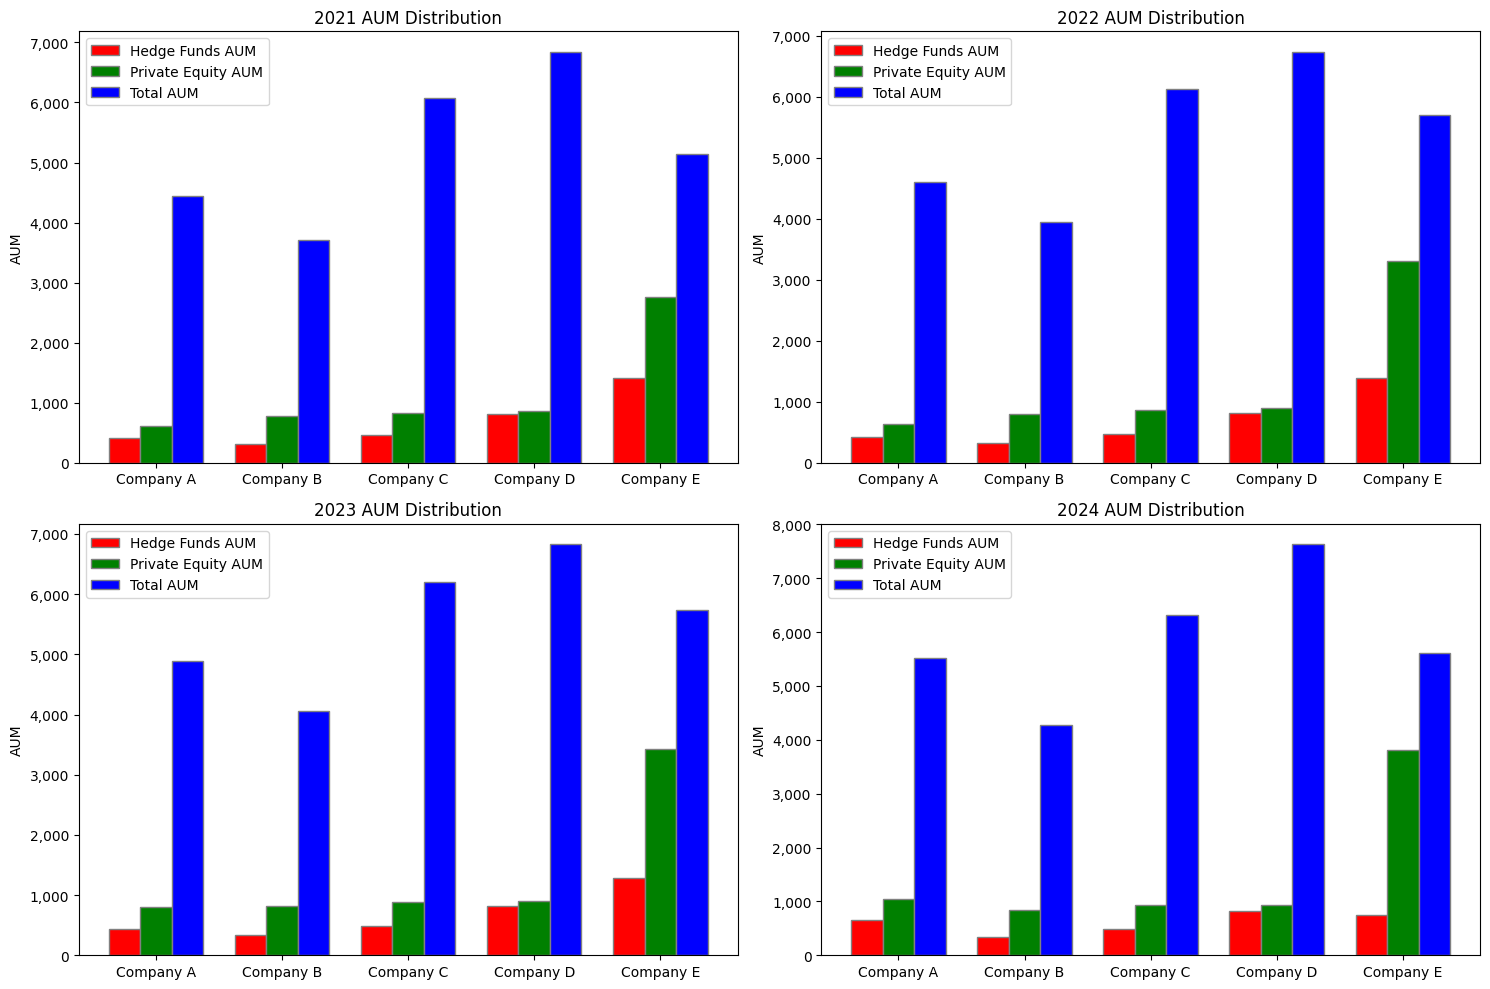

In [11]:
# Get the list of all unique companies across all years
companies = df_pivot['Manager Name'].unique()

# Get the unique years excluding 2020
years = df_pivot[df_pivot['Year'] != 2020]['Year'].unique()

# Set the width of the bars
barWidth = 0.25

# Calculate the number of rows needed for subplots
n_rows = int(np.ceil(len(years) / 2))

# Create a grid of subplots with adjusted figsize
fig, axs = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, year in enumerate(years):
    # Filter for the specific year and reindex to the list of all companies
    df_agg = df_pivot[df_pivot['Year'] == year].set_index('Manager Name').reindex(companies, fill_value=0).reset_index()

    # Set position of bar on X axis
    r1 = np.arange(len(companies))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Make the plot
    axs[i].bar(r1, df_agg['Hedge Funds AUM'], color='r', width=barWidth, edgecolor='grey', label='Hedge Funds AUM')
    axs[i].bar(r2, df_agg['Private Equity AUM'], color='g', width=barWidth, edgecolor='grey', label='Private Equity AUM')
    axs[i].bar(r3, df_agg['Total AUM'], color='b', width=barWidth, edgecolor='grey', label='Total AUM')

    # Adding xticks
    axs[i].set_xticks([r + barWidth for r in range(len(companies))])
    axs[i].set_xticklabels(companies)

    # Format y-axis
    axs[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    axs[i].set_ylabel('AUM')
    axs[i].set_title(f'{year} AUM Distribution')
    axs[i].legend()

# Remove any unused subplots
if len(years) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

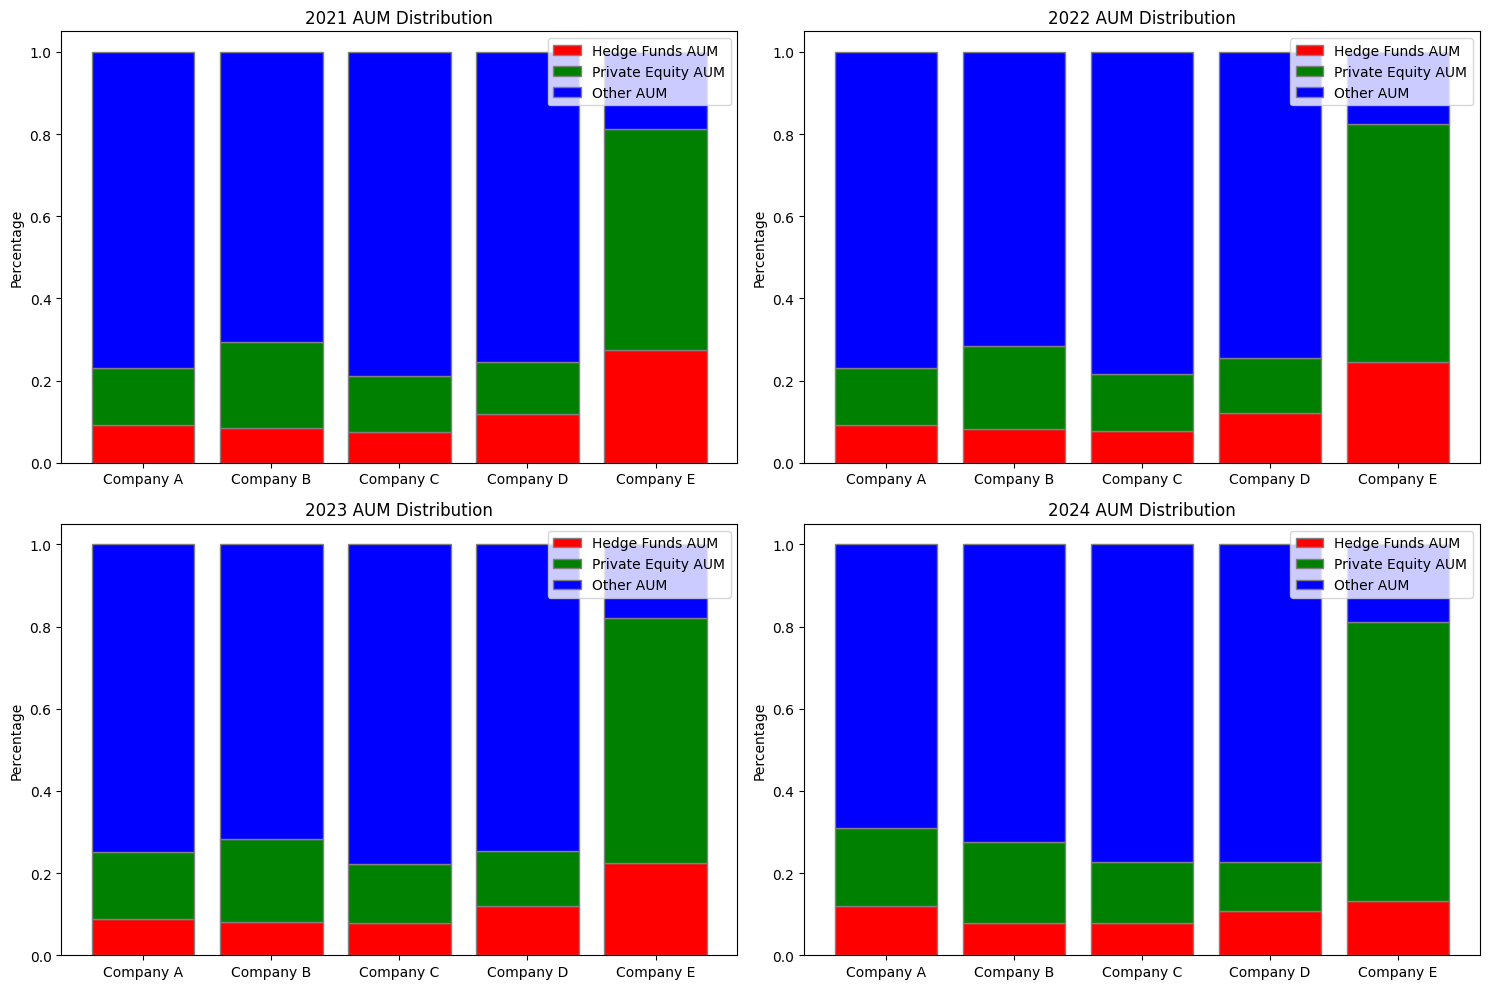

In [12]:


# Get the unique years excluding 2020
years = df_pivot[df_pivot['Year'] != 2020]['Year'].unique()

# Create a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Flatten the axes array for easy iteration
axs = axs.flatten()

for i, year in enumerate(years):
    # Filter for the specific year and reindex to the list of all companies
    df_agg = df_pivot[df_pivot['Year'] == year].set_index('Manager Name').reindex(companies, fill_value=0).reset_index()

    # Normalize the data to represent percentages
    df_agg['Hedge Funds AUM'] = df_agg['Hedge Funds AUM'] / df_agg['Total AUM']
    df_agg['Private Equity AUM'] = df_agg['Private Equity AUM'] / df_agg['Total AUM']
    df_agg['Other AUM'] = 1 - df_agg['Hedge Funds AUM'] - df_agg['Private Equity AUM']  # Assuming 'Other AUM' is the remaining part

    # Create the 100% stacked bar chart
    axs[i].bar(df_agg['Manager Name'], df_agg['Hedge Funds AUM'], color='r', edgecolor='grey')
    axs[i].bar(df_agg['Manager Name'], df_agg['Private Equity AUM'], bottom=df_agg['Hedge Funds AUM'], color='g', edgecolor='grey')
    axs[i].bar(df_agg['Manager Name'], df_agg['Other AUM'], bottom=df_agg['Hedge Funds AUM'] + df_agg['Private Equity AUM'], color='b', edgecolor='grey')

    axs[i].set_ylabel('Percentage')
    axs[i].set_title(f'{year} AUM Distribution')
    axs[i].legend(['Hedge Funds AUM', 'Private Equity AUM', 'Other AUM'])

plt.tight_layout()
plt.show()

# Pricing 

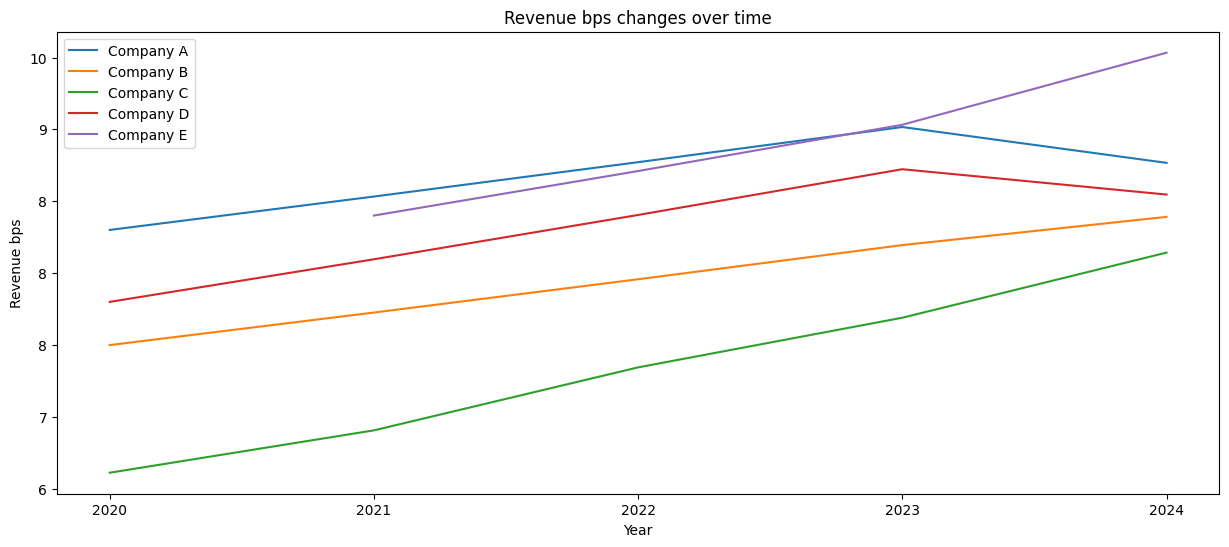

In [13]:
# line chart for 'Revenue bps' over the years
fig, ax = plt.subplots(figsize=(15,6))

for company in companies:
    company_data = df_pivot[df_pivot['Manager Name'] == company]
    ax.plot(company_data['Year'], company_data['Revenue bps'], label=company)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xlabel('Year')
ax.set_ylabel('Revenue bps')
ax.set_title('Revenue bps changes over time')
ax.legend()

plt.show()



## Identified Issues:
- Original data was enclosed in single quotes
- Some values were missing, -> filled with 0
- Some values were provided as integers and some as floats, ->  formatted them to be all same
- No 'Total AUM' data for Company A but asset split provided, ->  used that to calculate 'Total AUM'
- SUM of 'Split AUM' and 'Total AUM' did not  match for Company C, -> i used SUM of 'Split AUM'
- AUM and Revenue original values were of the same magnitude, -> i assume in my analysis that AUM figures were provided as milions('000,000), and revenue in thounsands ('000) 
- Company E no data available for 2020, removed from analysis
- Company C 2022 Fixed Income AUM seems to be an error, value more then double from 2021, and drops back to trending amount in 2023, -> replaced with average value
- Same for Total Revenue for Company C for 2022